## Анализ эффективности маркетинговой кампании

In [41]:
import numpy as np
import pandas as pd
import kagglehub
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

Даны **два датасета**, в которых представлены результаты А/В эксперимента. Будем считать, что выборки сформированы случайным образом и эксперимент проведен корректно (в одинаковых условиях для обеих групп). В датасетах посчитаны метрики, показывающие эффективность двух маркетинговых кампаний (тестовой и контрольной). Необходимо определить, **насколько тестовая кампания эффективнее или не эффективнее контрольной**.

### 1. Предварительная обработка данных

In [56]:
# Загружаю датасет
path = kagglehub.dataset_download("amirmotefaker/ab-testing-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\kirill\.cache\kagglehub\datasets\amirmotefaker\ab-testing-dataset\versions\1


In [59]:
# Формирую тестовую и контрольную группы
control = pd.read_csv(path + '/control_group.csv', sep=';')
test = pd.read_csv(path + '/test_group.csv', sep=';')

In [58]:
control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     int64  
 3   # of Impressions     29 non-null     float64
 4   Reach                29 non-null     float64
 5   # of Website Clicks  29 non-null     float64
 6   # of Searches        29 non-null     float64
 7   # of View Content    29 non-null     float64
 8   # of Add to Cart     29 non-null     float64
 9   # of Purchase        29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB


In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 non-null     object
 1   Date                 30 non-null     object
 2   Spend [USD]          30 non-null     int64 
 3   # of Impressions     30 non-null     int64 
 4   Reach                30 non-null     int64 
 5   # of Website Clicks  30 non-null     int64 
 6   # of Searches        30 non-null     int64 
 7   # of View Content    30 non-null     int64 
 8   # of Add to Cart     30 non-null     int64 
 9   # of Purchase        30 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 2.5+ KB


In [64]:
# Формирую один датасет для последующего расчета метрик
total = pd.concat([control, test])

In [65]:
# Форматирую колонки для удобства
total = total.rename(columns={'Campaign Name': 'Campaign_Name',
                                  'Spend [USD]':'Spend_USD',
                                  '# of Impressions':'n_of_Impressions',
                                  '# of Website Clicks': 'n_of_Website_Clicks',
                                  '# of Searches':'n_of_Searches',
                                  '# of View Content':'n_of_View_Content',
                                  '# of Add to Cart':'n_of_Add_to_Cart',
                                  '# of Purchase': 'n_of_Purchase'})

In [66]:
# Привожу дату в корректный формат, а также немного форматирую итоговой датасет
total.Date = pd.to_datetime(total.Date, format = '%d.%m.%Y')
total = total.sort_values(by = 'Date').reset_index()
del total['index']

In [69]:
# Смотрим итоговый датасет
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign_Name        60 non-null     object        
 1   Date                 60 non-null     datetime64[ns]
 2   Spend_USD            60 non-null     int64         
 3   n_of_Impressions     59 non-null     float64       
 4   Reach                59 non-null     float64       
 5   n_of_Website_Clicks  59 non-null     float64       
 6   n_of_Searches        59 non-null     float64       
 7   n_of_View_Content    59 non-null     float64       
 8   n_of_Add_to_Cart     59 non-null     float64       
 9   n_of_Purchase        59 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 4.8+ KB


In [70]:
# В отдельных столбцах есть пропущенные значения
total.isnull().sum()

Campaign_Name          0
Date                   0
Spend_USD              0
n_of_Impressions       1
Reach                  1
n_of_Website_Clicks    1
n_of_Searches          1
n_of_View_Content      1
n_of_Add_to_Cart       1
n_of_Purchase          1
dtype: int64

In [71]:
# Найдем строку с пропущенными значениями. 
total[total.isnull().any(axis=1)]

,Campaign_Name,Date,Spend_USD,n_of_Impressions,Reach,n_of_Website_Clicks,n_of_Searches,n_of_View_Content,n_of_Add_to_Cart,n_of_Purchase
8,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# Это 5 августа 2019 года. Уберем эту дату из тестирования для корректности резульататов
total = total.query('Date != "2019-08-05"')

C:\Users\kirill\AppData\Local\Temp\ipykernel_19744\169019343.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  total = total.query('Date != "2019-08-05"')


In [75]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 0 to 59
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign_Name        58 non-null     object        
 1   Date                 58 non-null     datetime64[ns]
 2   Spend_USD            58 non-null     int64         
 3   n_of_Impressions     58 non-null     float64       
 4   Reach                58 non-null     float64       
 5   n_of_Website_Clicks  58 non-null     float64       
 6   n_of_Searches        58 non-null     float64       
 7   n_of_View_Content    58 non-null     float64       
 8   n_of_Add_to_Cart     58 non-null     float64       
 9   n_of_Purchase        58 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 5.0+ KB


### 2. Определение целевых и прокси метрик для анализа эффективности маркетинговых кампаний

##### Целевые метрики:  
1. Стоимость привлечения пользователя (общие затраты на кампанию / количество покупок)
2. Конверсия в оплату (покупки/охват)


##### Прокси метрики:  
1. Общее число кликов
2. Число пользователей, добавивших товар в корзину
3. Промежуточные коневрсии (Показы - Клики, Клики - Просмотр контента, Просмотры - добавление в корзину)

In [82]:
# Для тестовой и контрольной группы считаем метрики для последующего подсчета конверсионных метрик
metrics = total.groupby(['Campaign_Name'], as_index=False) \
     .agg({'Spend_USD':'sum',
           'n_of_Impressions':'sum',
           'Reach':'sum',
           'n_of_Website_Clicks':'sum',
           'n_of_View_Content':'sum',
           'n_of_Add_to_Cart':'sum',
           'n_of_Purchase':'sum'})

In [84]:
metrics

,Campaign_Name,Spend_USD,n_of_Impressions,Reach,n_of_Website_Clicks,n_of_View_Content,n_of_Add_to_Cart,n_of_Purchase
0,Control Campaign,66818,3177233.0,2576503.0,154303.0,56370.0,37700.0,15161.0
1,Test Campaign,74595,2123249.0,1509609.0,175107.0,54882.0,25490.0,14869.0


In [98]:
# Рассчитываем целевые и вспомогательные конверсионные метрики
metrics['CR_pay'] = metrics.n_of_Purchase / metrics.n_of_Impressions * 100 # конверсия из показов рекламы в покупку
metrics['CR_cart'] = metrics.n_of_Add_to_Cart / metrics.n_of_View_Content * 100 # конверсия из просмотра контента в добавление в корзину
metrics['CR_view'] = metrics.n_of_View_Content / metrics.n_of_Website_Clicks * 100 # конверсия из кликов на сайте в просмотр контента
metrics['CTR'] = metrics.n_of_Website_Clicks / metrics.n_of_Impressions * 100 # конверсия из показов объявлений в клики на сайте
metrics['CPA'] = metrics.Spend_USD / metrics.n_of_Purchase # стоимость привлечения клиента
metrics['n_not_Purchase'] = metrics.n_of_Impressions - metrics.n_of_Purchase # количество не перешедших в покупку пользователей

In [99]:
metrics

,Campaign_Name,Spend_USD,n_of_Impressions,Reach,n_of_Website_Clicks,n_of_View_Content,n_of_Add_to_Cart,n_of_Purchase,CR_pay,CR_cart,CR_view,CTR,CPA,n_not_Purchase
0,Control Campaign,66818,3177233.0,2576503.0,154303.0,56370.0,37700.0,15161.0,0.477176,66.879546,36.532018,4.856521,4.407229,3162072.0
1,Test Campaign,74595,2123249.0,1509609.0,175107.0,54882.0,25490.0,14869.0,0.700295,46.445100,31.341979,8.247125,5.016814,2108380.0


### 3. А/В тестирование целевых метрик (CR_pay, количество покупок)

#### 3.1. Конверсия в покупку

In [192]:
# Выведем значение метрики конверсия в покупку в тестовой и контрольной группах
CR_pay = metrics[['Campaign_Name','CR_pay']]
CR_pay

,Campaign_Name,CR_pay
0,Control Campaign,0.477176
1,Test Campaign,0.700295


In [193]:
# Посчитаем на сколько изменилась метрика в тестовой группе
CR_pay = metrics[['Campaign_Name','CR_pay']]
CR_control = CR_pay.query('Campaign_Name == "Control Campaign"').CR_pay.iloc[0]
CR_test = CR_pay.query('Campaign_Name == "Test Campaign"').CR_pay.iloc[0]
percent_of_change = round((CR_test - CR_control) / CR_control * 100,2)

In [191]:
print(f"Значение конверсии в тестовой группе увеличилось на {percent_of_change}%.") 

Значение конверсии в тестовой группе увеличилось на 46.76%.


После подсчета метрик видно, что значение конверсии *увеличилось*. Необходимо проверить результат с помощью **АБ тестирования**.  

Для начала сформулируем **гипотезы**:  
$H0$ - значения конверсии в тестовой и контрольной группах равны  
$H1$ - значения конверсии в тестовой и контрольной группах отличаются

Определим **уровень значимости** (вероятность отклонить нулевую гипотезу, если она верна, то есть **ошибки первого рода**):   
$\alpha = 0.05$

In [196]:
# Составим таблицу сопряженности
chi_test_cr_pay = metrics[['n_of_Purchase', 'n_not_Purchase']]
chi_test_cr_pay

,n_of_Purchase,n_not_Purchase
0,15161.0,3162072.0
1,14869.0,2108380.0


In [197]:
#Используем критерий Хи-квадрат, для определения статзначимости различий между выборками
stat, p, dof, expected = st.chi2_contingency(chi_test_cr_pay)
print(f"Значение статистики = {stat:.4f}")
print(f"p-value = {p:.4f}")
print(f"Степени свободы = {dof}")
print("Ожидаемые значения:\n", expected)

Значение статистики = 1124.2950
p-value = 0.0000
Степени свободы = 1
Ожидаемые значения:
 [[  18000.68503015 3159232.31496985]
 [  12029.31496985 2111219.68503015]]


По результатам теста $p-value < \alpha$ **(равен нулю)**.  
Есть основания отвергнуть нулевую гипотезу.  
**Конверсия в покупку в тестовой группе увеличилась** (исходя из данных на 46%)

#### 3.2. Стоимость привлечения

In [357]:
total['CPA'] = total.Spend_USD/total.n_of_Purchase

In [356]:
CPA = total.groupby('Campaign_Name', as_index=False).agg({'CPA':'mean'})

In [358]:
CPA

,Campaign_Name,CPA
0,Control Campaign,5.052339
1,Test Campaign,5.999890


In [359]:
count_control= CPA.query('Campaign_Name == "Control Campaign"').CPA.iloc[0]
count_test = CPA.query('Campaign_Name == "Test Campaign"').CPA.iloc[0]
percent_per_count = round(abs((count_test - count_control) / count_test * 100),2)

In [362]:
print(f"Стоимость привлечения пользователей в тестовой группе увеличилось на {percent_per_count}%.") 

Стоимость привлечения пользователей в тестовой группе увеличилось на 15.79%.


Сформулируем **гипотезы**:  
$H0$ - CPA в тестовой и контрольной группах равны  
$H1$ - CPA тестовой и контрольной группах отличаются

Определим **уровень значимости** (вероятность отклонить нулевую гипотезу, если она верна, то есть **ошибки первого рода**):   
$\alpha = 0.05$

Исследуем значения в двух выборках (проверим данные на аномалии, **нормальность** и **равенство дисперсий**)

In [363]:
CPA_control = total.query('Campaign_Name == "Control Campaign"').CPA
CPA_test = total.query('Campaign_Name == "Test Campaign"').CPA

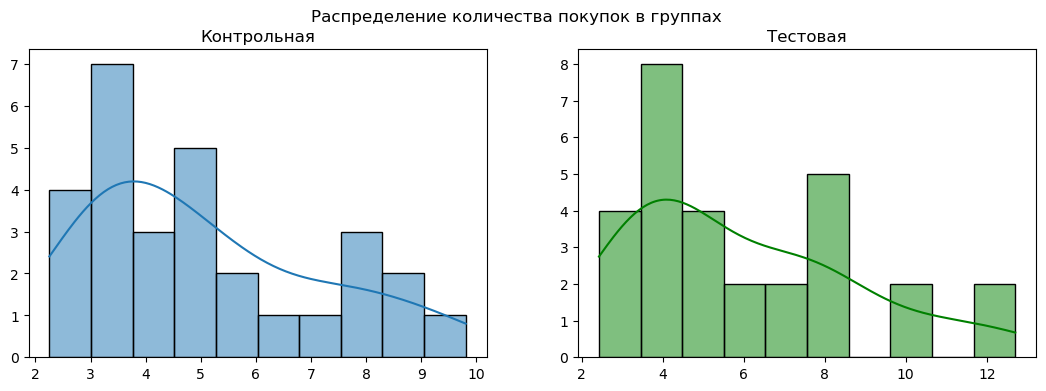

In [365]:
# Посмотрим на распределение и аномалии в данных
plt.figure(figsize=(13,4))
plt.suptitle('Распределение количества покупок в группах')

plt.subplot(1,2,1)
plt.title('Контрольная')
sns.histplot(data = CPA_control, bins=10, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
plt.title('Тестовая')
sns.histplot(data = CPA_test, color='g', bins=10, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.show()

Проверим данные на **нормальность**

In [367]:
# Используем метод Шапиро-Уилка для небольших выборок
pg.normality(data = total, dv = 'CPA', group='Campaign_Name', method='shapiro')

,W,pval,normal
Campaign_Name,,,
Control Campaign,0.913187,0.020564,False
Test Campaign,0.902387,0.011180,False


Визуально оценим нормальность распределения выборок c помощью QQ-графиков

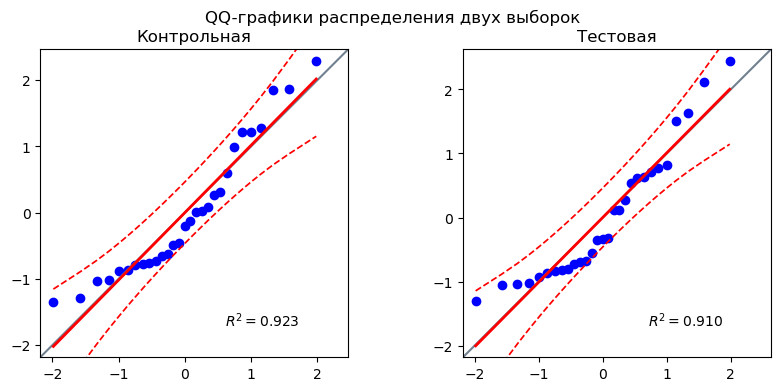

In [368]:
plt.figure(figsize=(10,4))
plt.suptitle('QQ-графики распределения двух выборок')

plt.subplot(1,2,1)
pg.qqplot(CPA_control)
plt.title('Контрольная')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
pg.qqplot(CPA_test)
plt.title('Тестовая')
plt.xlabel('')
plt.ylabel('')

plt.show()

Ненормальностью тестовой выборки можно принебречь, так как распределение **умеренно отличается от нормального**, а также при таком объеме выборки будет применятся **центральная предельная теорема**.

In [370]:
# Проверим равенство дисперсий выборок
pg.homoscedasticity(data = total, dv = 'CPA', group='Campaign_Name', method='levene')

,W,pval,equal_var
levene,1.683778,0.199743,True


Так как дисперсии равны, а характер распределения нормальный (одна выборка близка к нормальному распределению) можно использовать **Т-тест Стьюдента** для проверки статзначимости различий между группами

In [374]:
pg.ttest(CPA_control, CPA_test, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.45533,52.171876,two-sided,0.151569,"[-2.25, 0.36]",0.382188,0.641,0.29856


По результатам теста $p-value > \alpha$ **(0.151569)**.  
Нет оснований отвергнуть нулевую гипотезу.  
**CPA не изменилось**

### ДАЛЕЕ ДЕЛАЮ ОПИСАТЕЛЬНЫЙ АНАЛИЗ ВСЕХ ОСТАЛЬНЫХ МЕТРИК, А ТАКЖЕ ВОРОНКУ ДЕЙСТВИЙ ПОЛЬЗОВАТЕЛЯ ДЛЯ АНАЛИЗА КОНВЕРСИИ НА КАЖДОМ ЭТАПЕ.